# TF-IDF and Word2Vec Analysis on Quotes Corpus

This notebook explores text representation methods on a dataset of quotes grouped by author:
- Text preprocessing (lowercasing, stopword removal, punctuation stripping)
- TF-IDF computation from scratch
- Word2Vec training with different hyperparameter configurations
- t-SNE visualization of word embeddings

## Data Loading and Preprocessing

In [1]:
import pandas as pd
import copy
from collections import Counter
import regex as re

file = "quotes.csv"

file_df = pd.read_csv(file)
df = copy.deepcopy(file_df)
df.drop('category', axis=1, inplace=True)
df = df.dropna()

In [2]:
unique_authors = df['author'].unique()
print(f'There are {len(unique_authors)} unique authors')

df_sorted = df.sort_values(by='author', ascending=False)

# Group all quotes by author into single documents
df_grouped = df_sorted.groupby('author', as_index=False)['quote'].agg(' '.join)

There are 117296 unique authors


In [3]:
import string
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_and_concatenate(quotes):
    cleaned_quotes = []
    for quote in quotes:
        quote = quote.lower()
        quote = ''.join(c if c not in string.punctuation else ' ' for c in quote)
        quote = ' '.join([word for word in quote.split() if word not in stop_words])
        cleaned_quotes.append(quote)
    return ' '.join(cleaned_quotes)

df_grouped = df_sorted.groupby('author', as_index=False)['quote'].agg(preprocess_and_concatenate)
df_grouped

[nltk_data] Downloading package stopwords to /Users/eitan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,author,quote
0,,les hommes construisent trop de murs et pas as...
1,everything starts with him. To all the boys ...,kiss every whim
2,where books are burnt human-beings will be b...,prelude
3,'Ego' is whatever within you stops you taking...,god whatever next obvious step towards wholene...
4,'Tis wise to learn: 'tis God-like to create!,tis well borrow good great
...,...,...
117291,東山翔,yeah truly wonderful movie could feel iq plumm...
117292,"顾漫, 微微一笑很倾城 [Just One Smile Is Very Alluring]",real life wasn’t game game required rashness s...
117293,"黃玉華, Three Cups of Tea: One Man's Mission to P...",first time share tea balti stranger second tim...
117294,미프진판매 홈피:bbh.ow.to ✉✉✉카톡:EEE388 텔레:EEE388,수면제판매 정품수면제 미프진카톡 eee388 bbh ow to카톡 eee388 bb...


## TF-IDF from Scratch

In [4]:
import math

def alphacharacters(string):
    r = r'[A-Za-z]'
    match = re.findall(r, string)
    return "".join(match)

# Sample 3 random authors
rand_i = df_grouped.sample(n=3)
selected_authors = list(rand_i['author'])

def author_common(df_row):
    """Selects 2 most common terms (4+ chars) from a given author's document"""
    string = df_row['quote']
    words = string.split()
    words_4 = []
    for each in words:
        each_alpha = alphacharacters(each)
        if len(each_alpha) >= 4:
            words_4.append(each)
    counter = Counter(words_4)
    return counter.most_common(2)

for i in range(len(selected_authors)):
    print(f'The two most common words for author {selected_authors[i]} are: {author_common(rand_i.iloc[i])}')

The two most common words for author Tony Crunk, New Covenant Bound are: [('racer', 1), ('snake', 1)]
The two most common words for author E.C "Teddy Blue" Abbott are: [('time', 3), ('never', 3)]
The two most common words for author Kimberly Perry, If I Die Young: Piano/Vocal/Chords, Sheet are: [('penny', 1), ('thoughts', 1)]


In [5]:
N = len(df_grouped)

def get_DF(word, dataframe):
    """DF: number of documents containing term 'word'"""
    def find_word_row(row):
        return word in row["quote"].split()
    return dataframe.apply(find_word_row, axis=1).sum()

def get_TF_IDF(df_row, N, dataframe):
    """
    Calculates TF-IDF of the 2 most common words in a given author's document.
    Returns list of [word, TF-IDF] pairs.
    """
    tup1, tup2 = author_common(df_row)
    w1, c1 = tup1
    w2, c2 = tup2
    freq_words = [[w1, c1], [w2, c2]]

    string = df_row['quote']
    words = string.split()
    total_term_count = len(words)

    output = []
    for each in freq_words:
        DF = get_DF(each[0], dataframe)
        TF = each[1] / total_term_count
        IDF = math.log(N / (1 + DF))
        TF_IDF = TF * IDF
        output.append([each[0], TF_IDF])
    return output

test_row = rand_i.iloc[1]
test = get_TF_IDF(test_row, N, df_grouped)
print(test)

[['time', 0.041165559132200824], ['never', 0.04252586590359895]]


## Word2Vec Training

Experimenting with two configurations:
- Window=3, Dimensions=50, Negative samples=3
- Window=7, Dimensions=150, Negative samples=10

In [6]:
from gensim.models import Word2Vec

def get_corpus(dataframe):
    return [row.split() for row in dataframe["quote"].dropna()]

processed_corpus = get_corpus(df_grouped)

model1 = Word2Vec(sentences=processed_corpus, vector_size=50, window=3, sg=1, min_count=1, negative=3)
model2 = Word2Vec(sentences=processed_corpus, vector_size=150, window=7, sg=1, min_count=1, negative=10)

print("Model 1 - most similar to 'imagination':")
print(model1.wv.most_similar(positive=["imagination"]))
print(f"Model 1 - similarity('fear', 'knowledge'): {model1.wv.similarity('fear', 'knowledge')}")

print("\nModel 2 - most similar to 'imagination':")
print(model2.wv.most_similar(positive=["imagination"]))
print(f"Model 2 - similarity('fear', 'knowledge'): {model2.wv.similarity('fear', 'knowledge')}")

Model 1 - most similar to 'imagination':
[('figment', 0.868111252784729), ('imaginative', 0.8678775429725647), ('creativity', 0.8576952219009399), ('figments', 0.8463994264602661), ('artistry', 0.8448479175567627), ('imaginations', 0.8368053436279297), ('confining', 0.8283895254135132), ('fantasy', 0.8267313838005066), ('daydream', 0.8267182111740112), ('marvels', 0.8258657455444336)]
Model 1 - similarity('fear', 'knowledge'): 0.687950611114502

Model 2 - most similar to 'imagination':
[('figments', 0.772416353225708), ('imaginative', 0.7618609070777893), ('daydreamer', 0.7612184882164001), ('figment', 0.7580222487449646), ('youthfulness', 0.7567988038063049), ('astonish', 0.7439024448394775), ('depreciate', 0.7436569929122925), ('fount', 0.7431842088699341), ('materiality', 0.7426494359970093), ('imaginations', 0.7417817711830139)]
Model 2 - similarity('fear', 'knowledge'): 0.5571901202201843


## t-SNE Visualization

Training a larger Word2Vec model and visualizing word relationships using t-SNE.

In [7]:
import multiprocessing

cores = multiprocessing.cpu_count()
w2v_model = Word2Vec(sentences=processed_corpus,
                     min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=cores-1)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("darkgrid")

from sklearn.manifold import TSNE

def tsnescatterplot(model, word, list_names):
    """t-SNE visualization: query word (red), 10 most similar (blue), additional words (green)"""
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list = ['red']

    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)

    close_words = model.wv.most_similar([word])
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)

    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)

    reduc = arrays
    np.set_printoptions(suppress=True)
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)

    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})

    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)

    p1 = sns.regplot(data=df, x="x", y="y", fit_reg=False, marker="o",
                     scatter_kws={'s': 40, 'facecolors': df['color']})

    for line in range(0, df.shape[0]):
        p1.text(df["x"][line], df['y'][line], '  ' + df["words"][line].title(),
                horizontalalignment='left', verticalalignment='bottom',
                size='medium', color=df['color'][line], weight='normal').set_size(15)

    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
    plt.title('t-SNE visualization for {}'.format(word.title()))
    plt.show()

In [14]:
key_words = ["imagination", "fear", "understanding", "discovery", "science"]

### 10 Most Similar vs. 11th-20th Most Similar
Red = keyword, Blue = 10 most similar, Green = 11th to 20th most similar

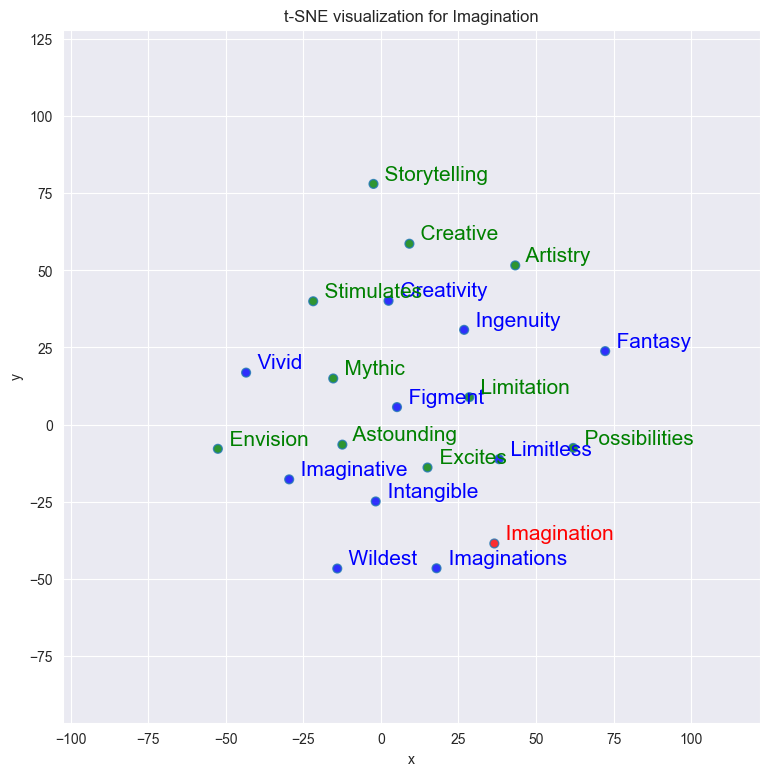

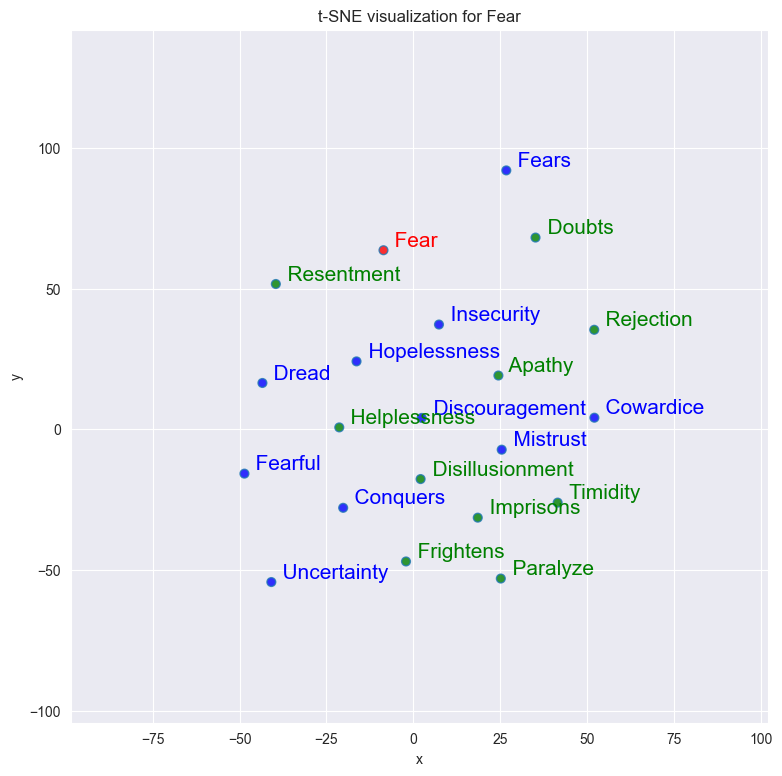

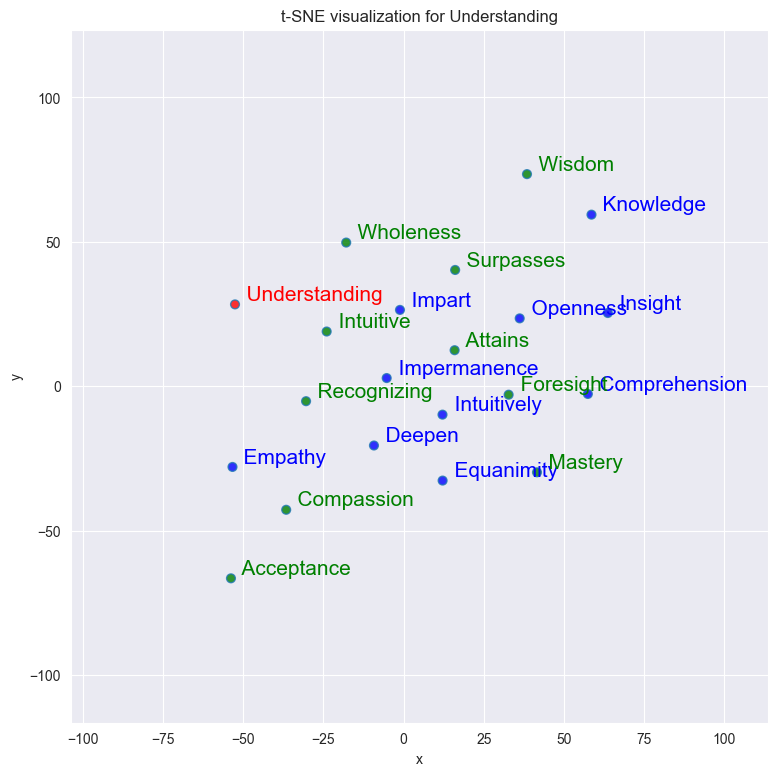

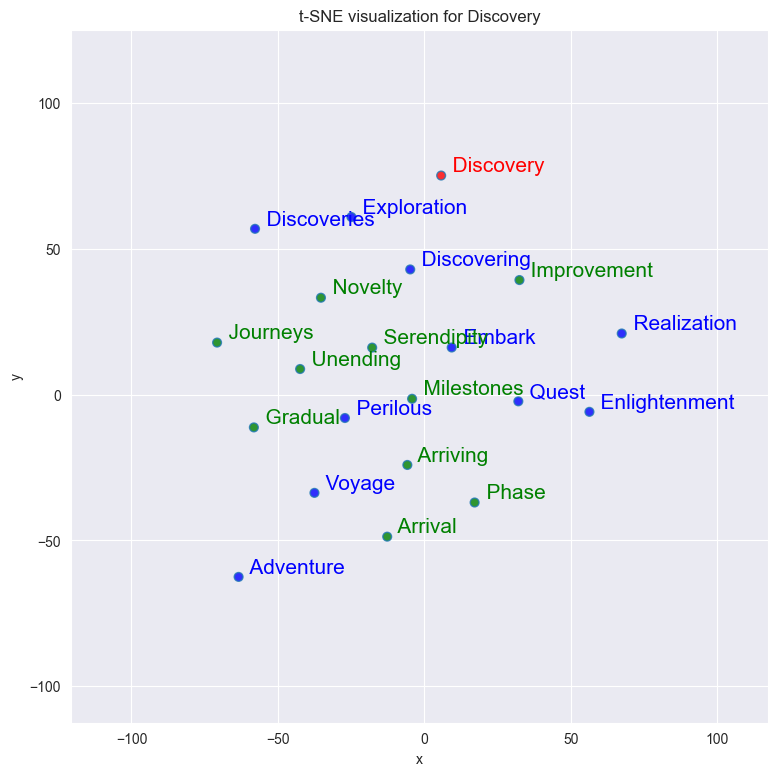

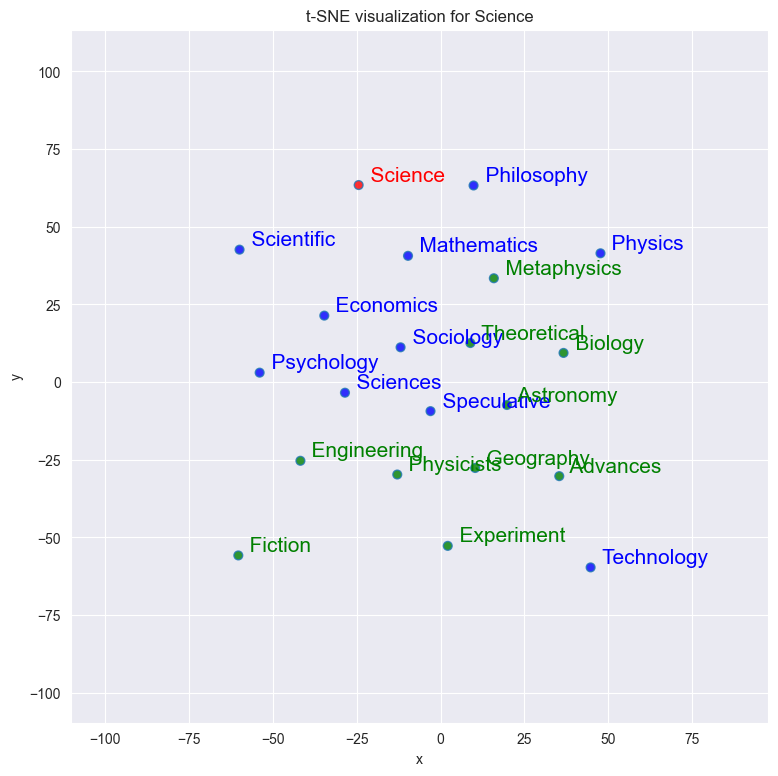

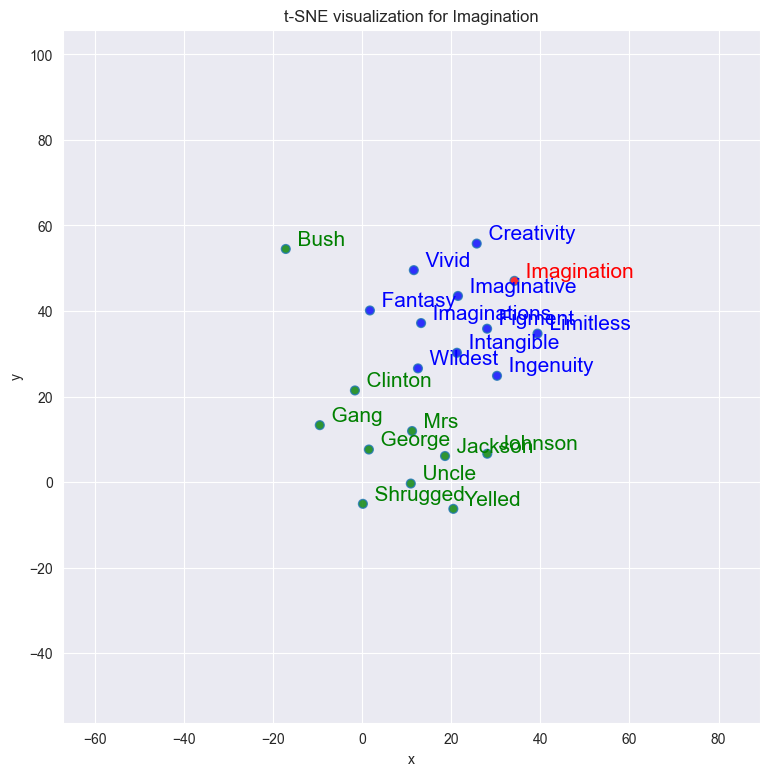

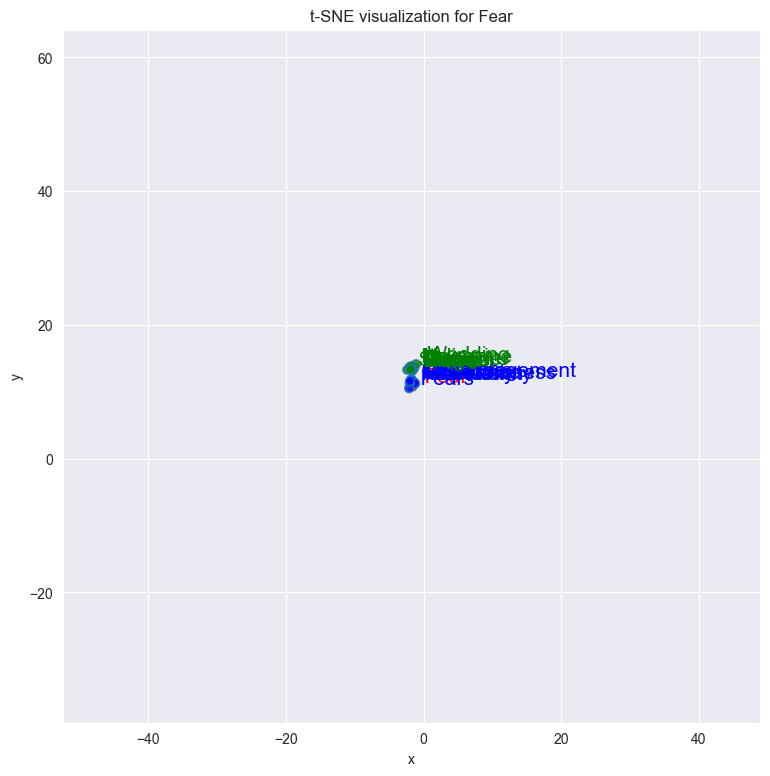

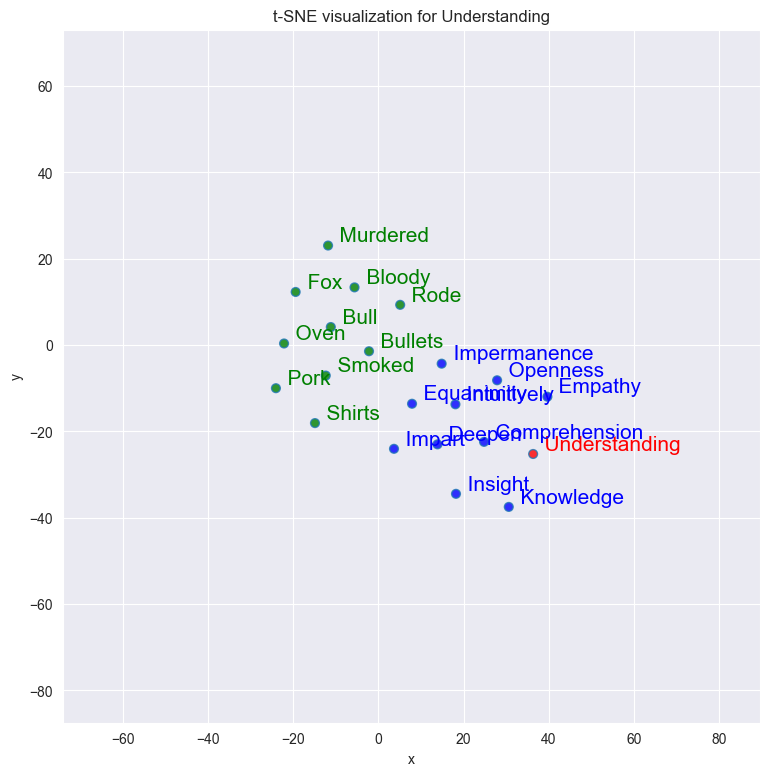

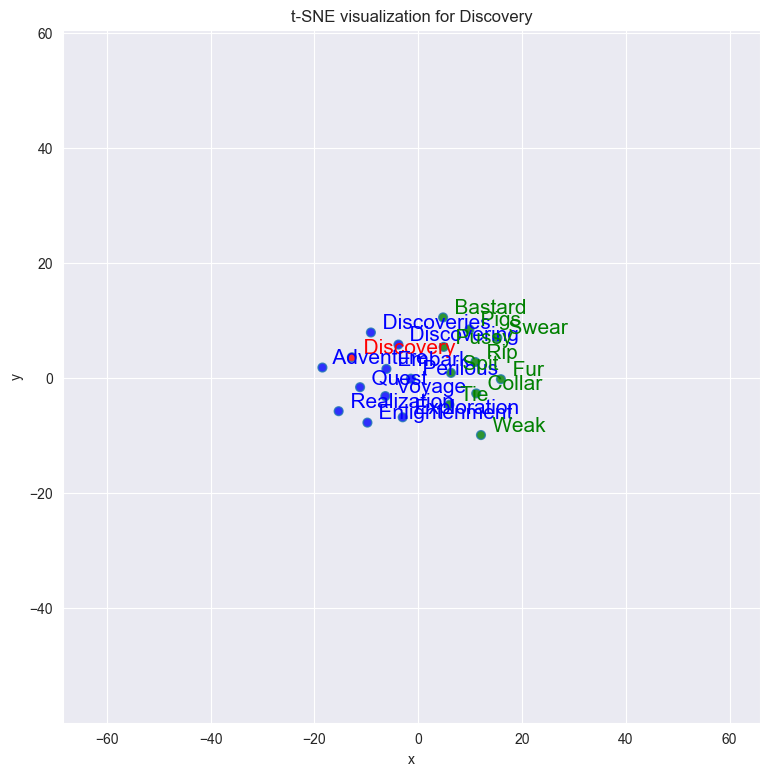

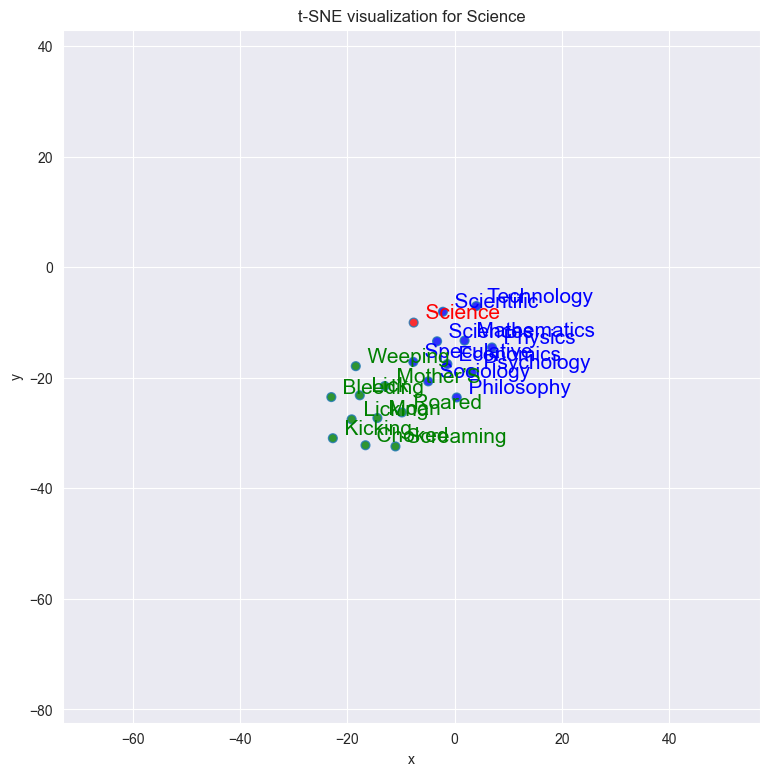

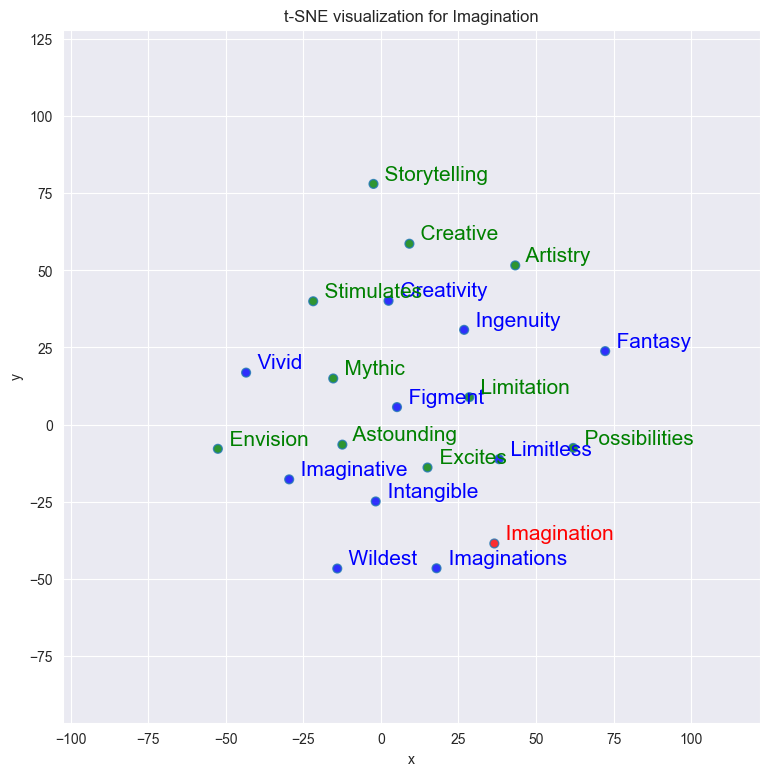

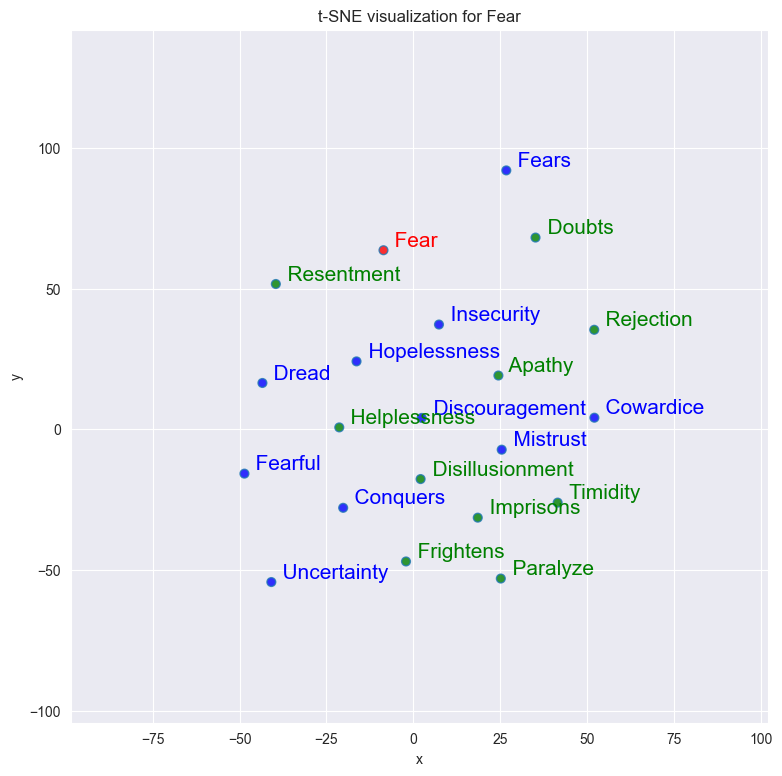

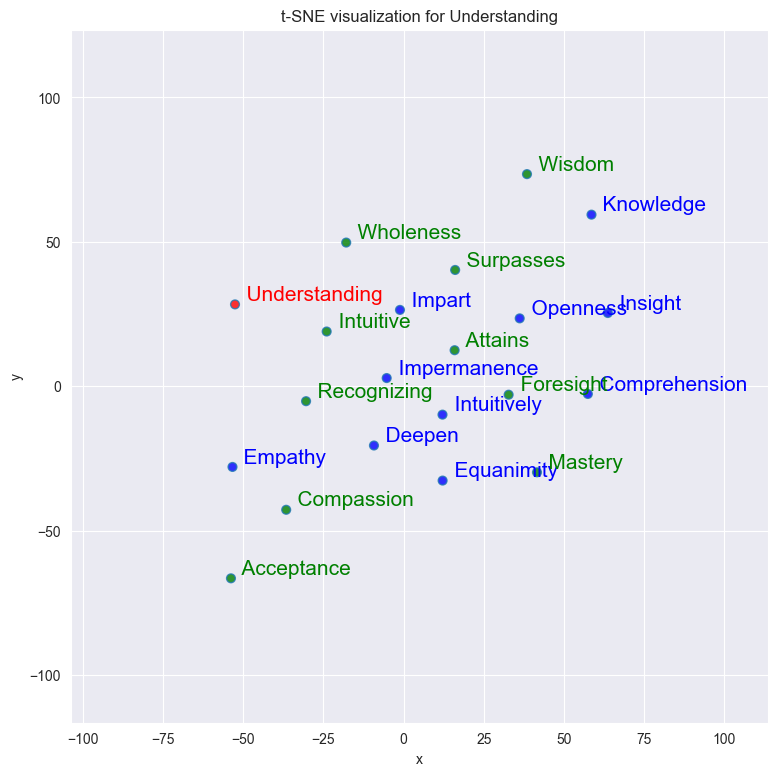

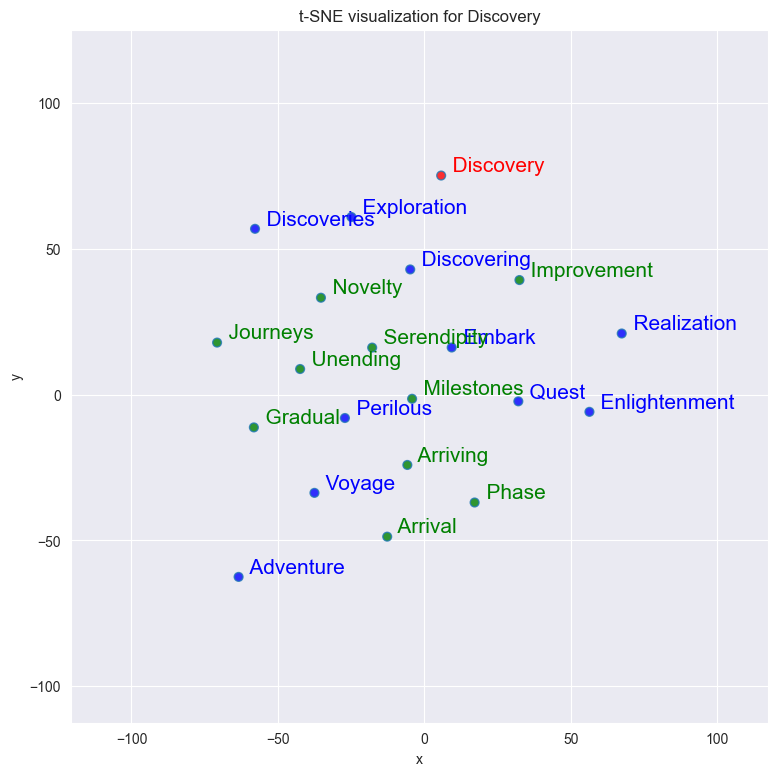

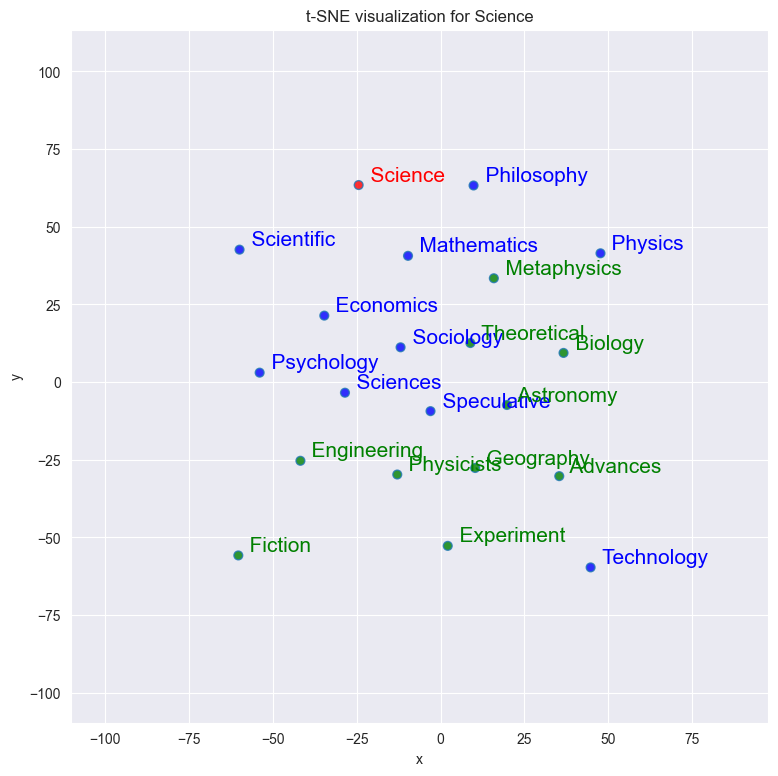

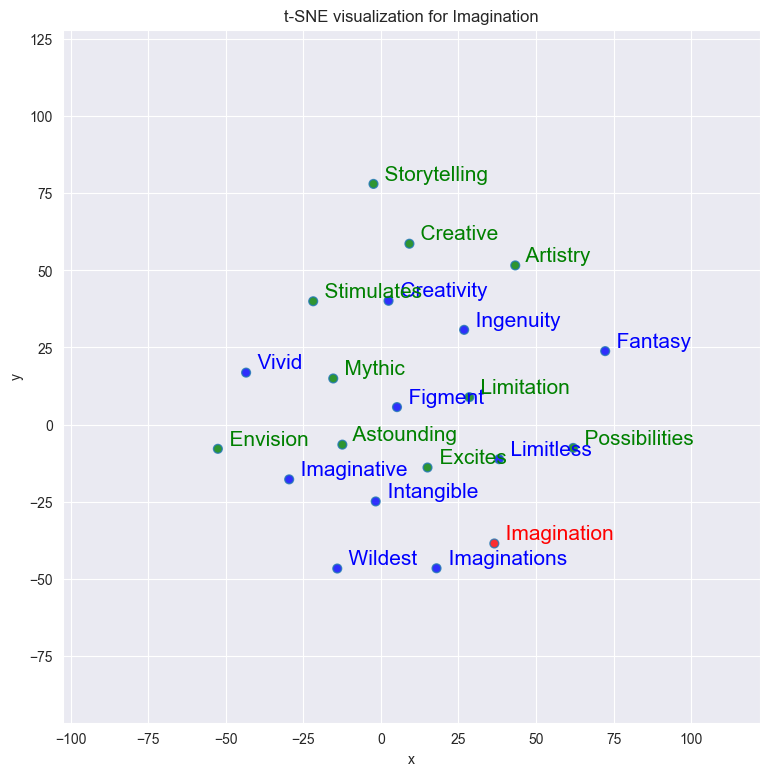

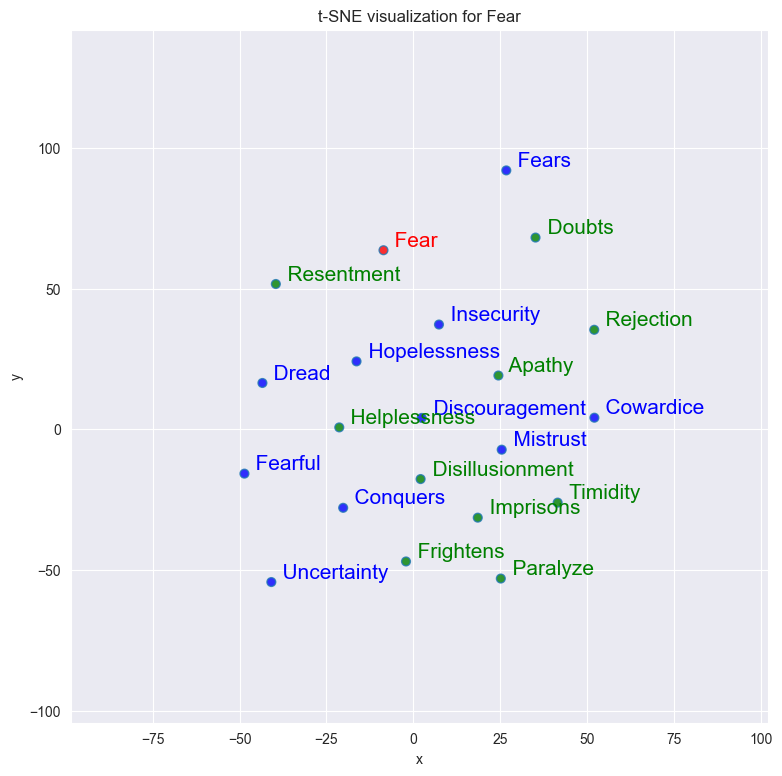

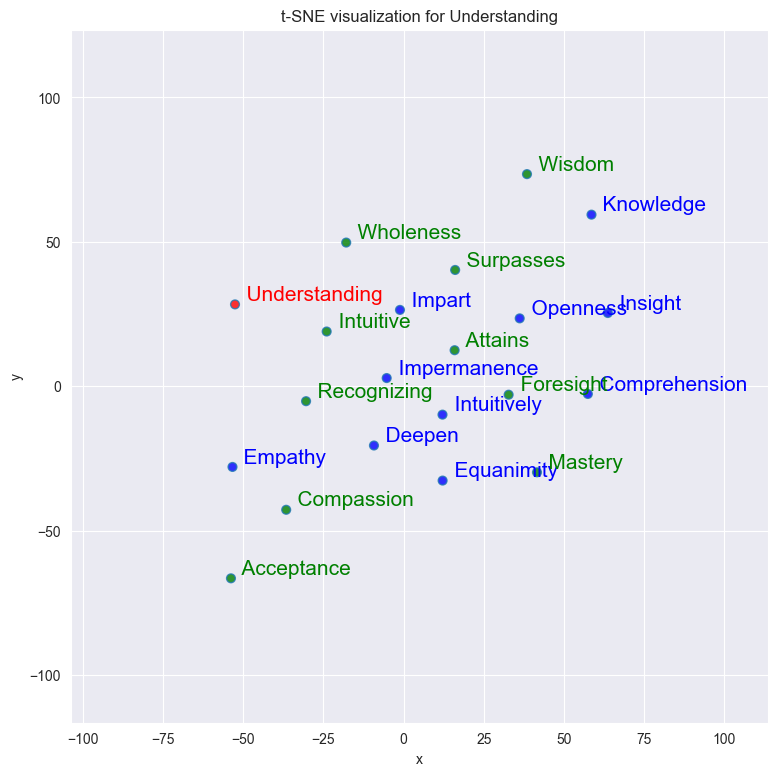

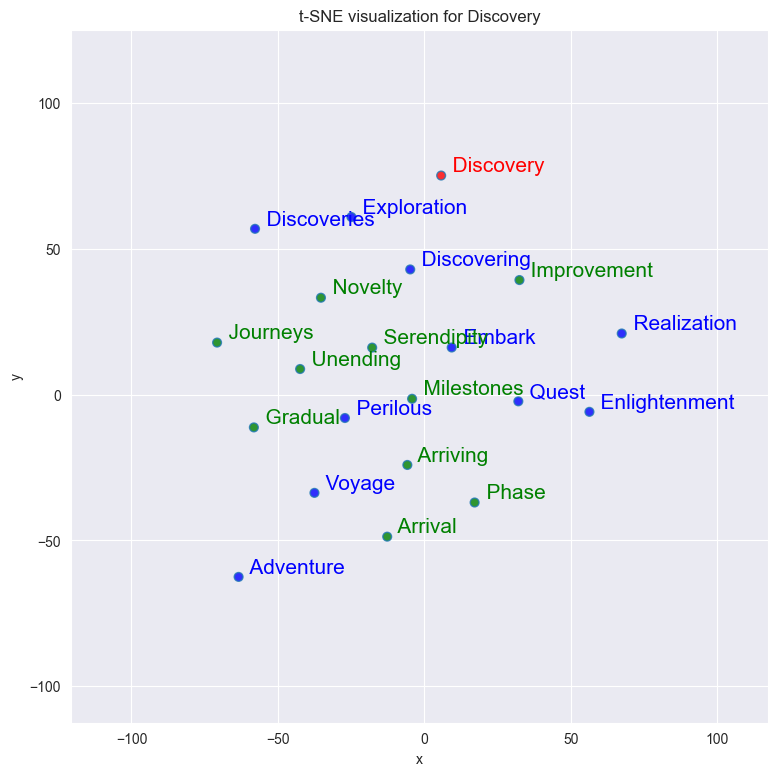

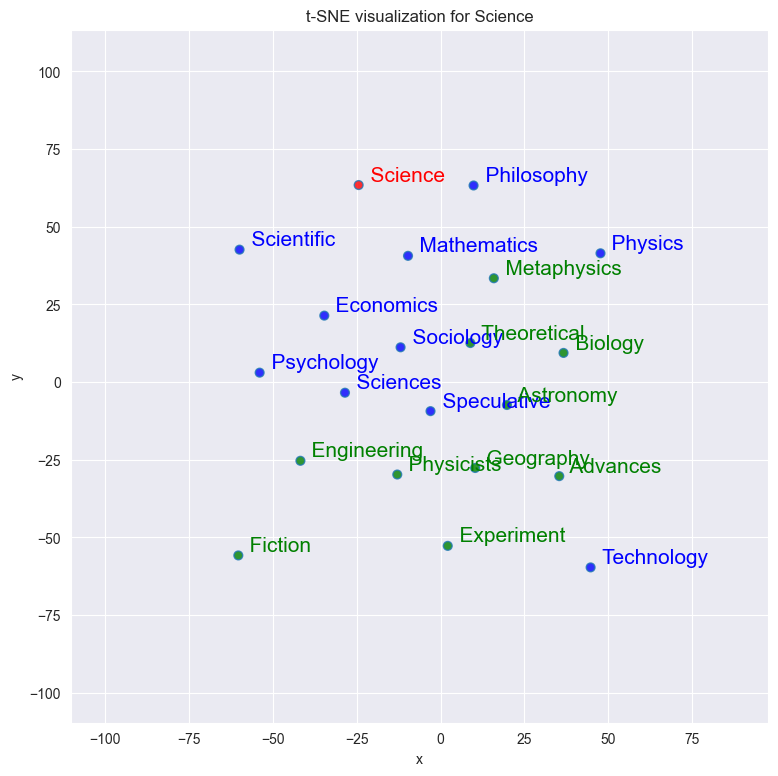

In [15]:
for word in key_words:
    tsnescatterplot(w2v_model, word, [t[0] for t in w2v_model.wv.most_similar(positive=[word], topn=20)][10:])

### 10 Most Similar vs. 10 Most Dissimilar
Red = keyword, Blue = 10 most similar, Green = 10 most dissimilar

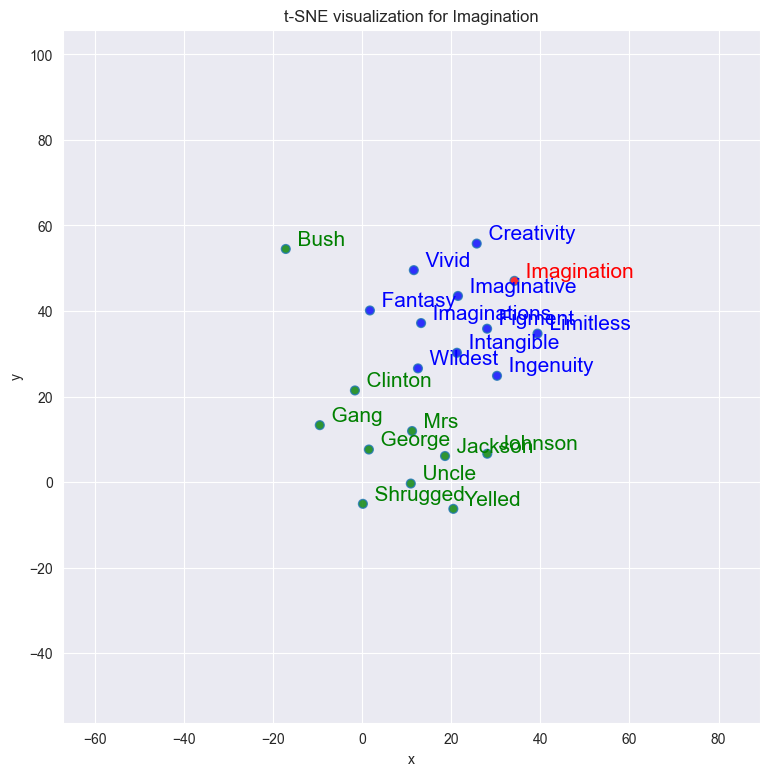

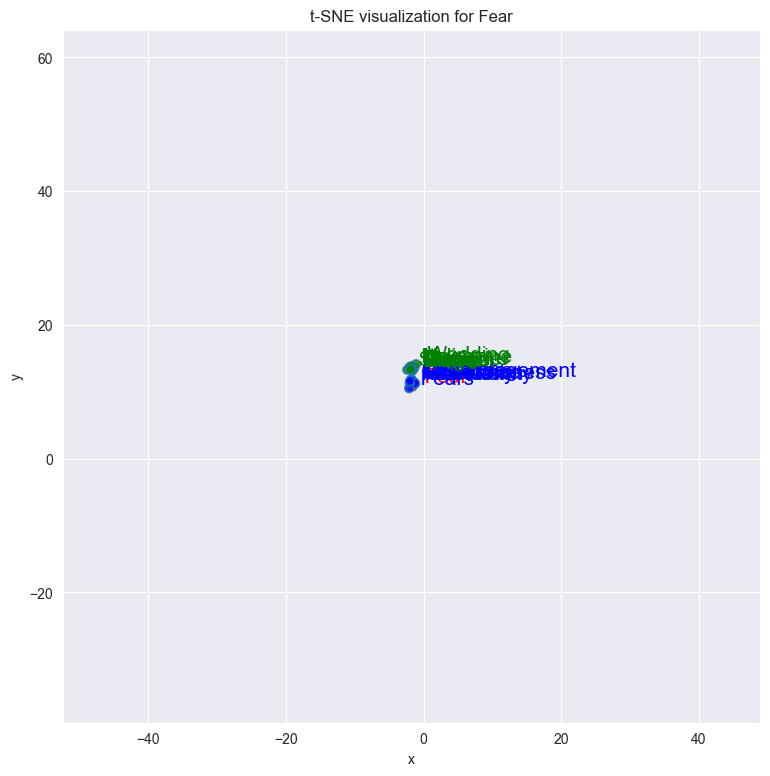

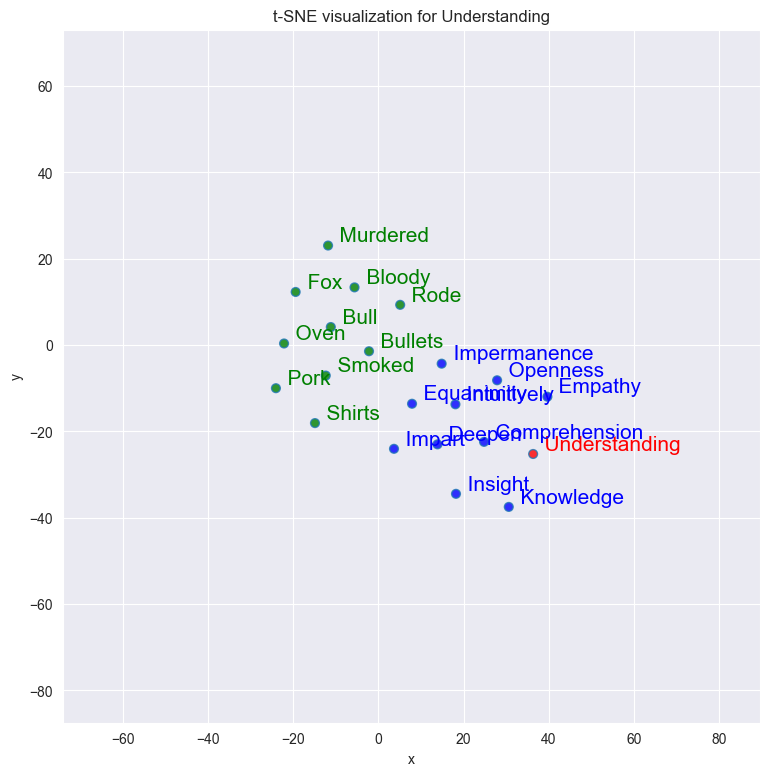

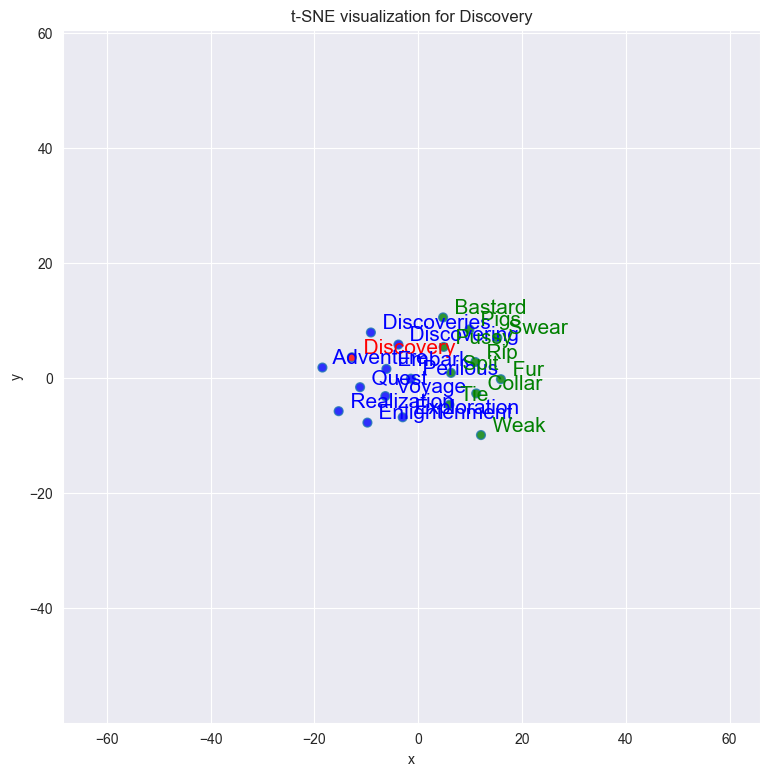

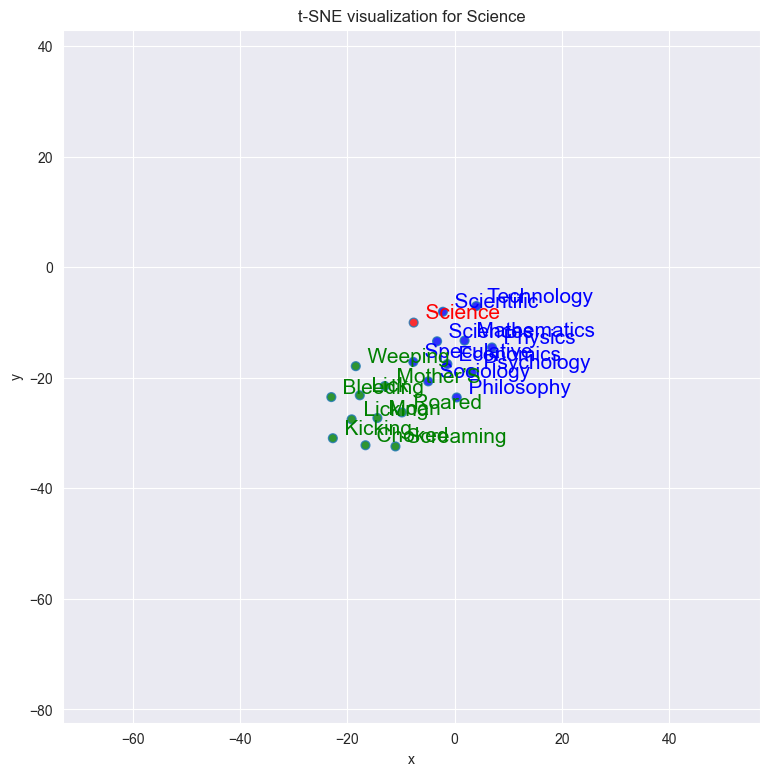

In [16]:
for word in key_words:
    tsnescatterplot(w2v_model, word, [i[0] for i in w2v_model.wv.most_similar(negative=[word])])